## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [10]:
import os
import keras
from keras.layers import BatchNormalization

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.1,0.4,0.8]
redice_lr_patient = [5,10]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)

    reduce_lr = ReduceLROnPlateau(factor= reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

Epoch 9/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3771 - acc: 0.5195 - val_loss: 1.5166 - val_acc: 0.4615
Epoch 10/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3512 - acc: 0.5281 - val_loss: 1.4984 - val_acc: 0.4706
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3261 - acc: 0.5371 - val_loss: 1.4980 - val_acc: 0.4669
Epoch 12/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3022 - acc: 0.5458 - val_loss: 1.4837 - val_acc: 0.4693
Epoch 13/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.2804 - acc: 0.5530 - val_loss: 1.4718 - val_acc: 0.4794
Epoch 14/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2589 - acc: 0.5612 - val_loss: 1.4788 - val_acc: 0.4786
Epoch 15/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2396 - acc: 0.5692 - val_loss: 1.4665 - val_acc: 0.4876
Epoch 16/25
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.2277 - acc: 0.2671 - val_loss: 2.1439 - val_acc: 0.1958
Epoch 2/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.7628 - acc: 0.3830 - val_loss: 1.9854 - val_acc: 0.2826
Epoch 3/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6374 - acc: 0.4269 - val_loss: 1.8350 - val_acc: 0.3628
Epoch 4/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.5654 - acc: 0.4509 - val_loss: 1.7199 - val_acc: 0.4005
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5115 - acc: 0.4709 - val_loss: 1.6422 - val_acc: 0.4232
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4688 - acc: 0.4848 - val_loss: 1.5764 - val_acc: 0.4498
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4293 - acc: 0.4980 - val_loss: 1.5527 - val_acc

50000/50000 [==============================] - 3s 53us/step - loss: 1.0477 - acc: 0.6413 - val_loss: 1.4384 - val_acc: 0.4948
Epoch 25/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.0316 - acc: 0.6481 - val_loss: 1.4612 - val_acc: 0.4874
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 3s 50us/step - loss: 0.8791 - acc: 0.6941 - val_loss: 1.6343 - val_acc: 0.4669
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.8370 - acc: 0.7100 - val_loss: 1.8646 - val_acc: 0.4227
Epoch 14/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.8047 - acc: 0.7199 - val_loss: 2.3049 - val_acc: 0.3626
Epoch 15/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.7693 - acc: 0.7323 - val_loss: 1.9114 - val_acc: 0.4266
Epoch 16/25
50000/50000 [==============================] - 2s 50us/step - loss: 0.7239 - acc: 0.7495 - val_loss: 1.9687 - val_acc: 0.4213
Epoch 17/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.6855 - acc: 0.7633 - val_loss: 1.9058 - val_acc: 0.4405
Epoch 18/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.6480 - acc: 0.7784
Epoch 00018: reducing learning rate to 0.00010000000474974513.
50000/50000 [

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.2276 - acc: 0.2675 - val_loss: 2.1727 - val_acc: 0.2431
Epoch 2/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.8467 - acc: 0.3616 - val_loss: 2.0316 - val_acc: 0.3023
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.7415 - acc: 0.3938 - val_loss: 1.9150 - val_acc: 0.3389
Epoch 4/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6819 - acc: 0.4121 - val_loss: 1.8046 - val_acc: 0.3725
Epoch 5/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6380 - acc: 0.4278 - val_loss: 1.7353 - val_acc: 0.3914
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6042 - acc: 0.4387 - val_loss: 1.6907 - val_acc: 0.4021
Epoch 7/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.5769 - acc: 0.4505 - val_loss: 1.6499 - val_acc

50000/50000 [==============================] - 2s 47us/step - loss: 1.3716 - acc: 0.5250 - val_loss: 1.5470 - val_acc: 0.4613
Epoch 25/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3633 - acc: 0.5295 - val_loss: 1.5459 - val_acc: 0.4609
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4884 - acc: 0.4811 - val_loss: 1.6005 - val_acc: 0.4362
Epoch 13/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4744 - acc: 0.4862 - val_loss: 1.5960 - val_acc: 0.4410
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4626 - acc: 0.4909 - val_loss: 1.5942 - val_acc: 0.4416
Epoch 15/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4497 - acc: 0.4953 - val_loss: 1.5850 - val_acc: 0.4453
Epoch 16/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4384 - acc: 0.4997 - val_loss: 1.5888 - val_acc: 0.4412
Epoch 17/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4284 - acc: 0.5029 - val_loss: 1.5804 - val_acc: 0.4422
Epoch 18/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4172 - acc: 0.5062 - val_loss: 1.5736 - val_acc: 0.4499
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 73us/step - loss: 2.5863 - acc: 0.1753 - val_loss: 2.2423 - val_acc: 0.1698
Epoch 2/25
50000/50000 [==============================] - 2s 47us/step - loss: 2.2586 - acc: 0.2492 - val_loss: 2.1789 - val_acc: 0.2045
Epoch 3/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.1018 - acc: 0.2919 - val_loss: 2.0876 - val_acc: 0.2464
Epoch 4/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.0011 - acc: 0.3193 - val_loss: 1.9850 - val_acc: 0.2956
Epoch 5/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.9273 - acc: 0.3400 - val_loss: 1.9118 - val_acc: 0.3214
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.8713 - acc: 0.3556 - val_loss: 1.8557 - val_acc: 0.3437
Epoch 7/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.8265 - acc: 0.3676 - val_loss: 1.8139 - val_acc

50000/50000 [==============================] - 2s 46us/step - loss: 1.5151 - acc: 0.4712 - val_loss: 1.6301 - val_acc: 0.4334
Epoch 25/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.5039 - acc: 0.4760 - val_loss: 1.6250 - val_acc: 0.4364
Numbers of exp: 15, reduce_factor: 0.40, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.6752 - acc: 0.4175 - val_loss: 1.7346 - val_acc: 0.3933
Epoch 13/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.6543 - acc: 0.4247 - val_loss: 1.7254 - val_acc: 0.3959
Epoch 14/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.6348 - acc: 0.4302 - val_loss: 1.7123 - val_acc: 0.4019
Epoch 15/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.6169 - acc: 0.4369 - val_loss: 1.7036 - val_acc: 0.4071
Epoch 16/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6010 - acc: 0.4406 - val_loss: 1.6959 - val_acc: 0.4097
Epoch 17/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5853 - acc: 0.4473 - val_loss: 1.6845 - val_acc: 0.4114
Epoch 18/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5692 - acc: 0.4529 - val_loss: 1.6770 - val_acc: 0.4125
Epoch 19/25
50000/50000 [=========

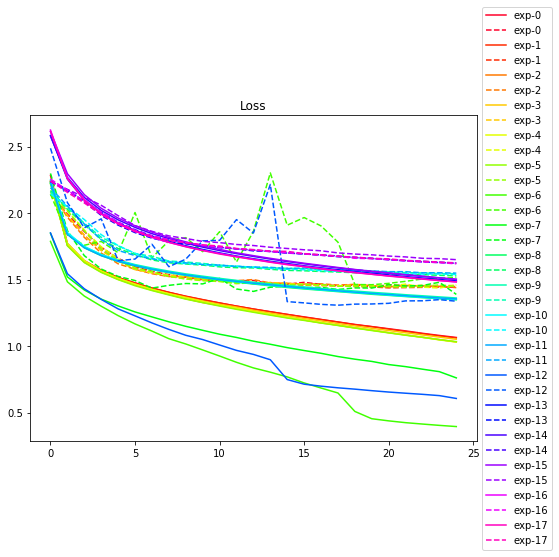

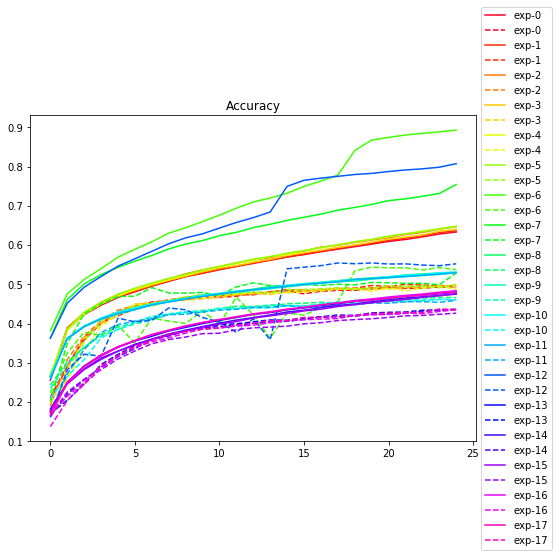

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()